# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print(u'столбец '+str(i)+': '+str(w))#+ (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

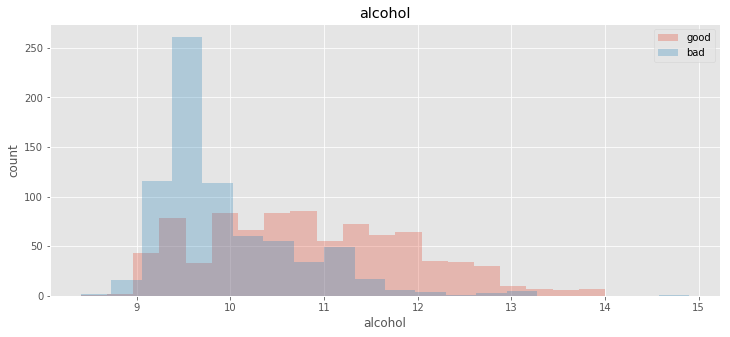

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print('Оптимальный порог: %f' % model.threshold)

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print('Доля ошибок на обучающей выборке: %f' % error_rate)

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print('Доля ошибок на контрольной выборке: %f' % error_rate)

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random'). 

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [48]:
from sklearn.base import ClusterMixin
from tqdm import tqdm
import sys
from scipy import stats

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', early_stop = False, verbose = True):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.early_stop = early_stop
        self.verbose = verbose
    def dist(self, x,y):
        if self.metric == 'euclidean':
            return np.linalg.norm(x-y)
        raise Exception('Wrong metric')
        
    def get_probability(self, x, p):
        p = p/sum(p)
        custm = stats.rv_discrete(name='custm', values=(x, p), )
        return custm.rvs()
    
    def KMeansPlus(self, X):
        centroids = np.empty((self.k, X.shape[1]))
        centroids[0] = X[np.random.choice(X.shape[0], 1, replace = False)]
        for k in range(0,self.k-1):
            dist = np.array([self.dist(centroids[k,:], i) for i in X])
            ind = self.get_probability(np.arange(X.shape[0]), dist)
            centroids[k+1,:] = X[ind]
        return centroids
    
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров

        ## Your Code Here
        delta = 1 # For early stop
        if   self.init=='random':
            self.centroids = X[np.random.choice(X.shape[0], self.k, replace = False)]
        elif self.init=='k-means++':
            self.centroids = self.KMeansPlus(X)
        else:  
            raise Exception('Wrong init')
        for i in tqdm(range(self.max_iter)) if self.verbose else range(self.max_iter):
            self.labels = np.array([np.argmin([self.dist(x,u) for u in self.centroids]) for x in X])
            if self.early_stop: centroids_last = self.centroids.copy()
            
            self.centroids = np.array([sum(X[np.where(self.labels == k)])*1.0/len(np.where(self.labels == k)[0]) if len(np.where(self.labels == k)[0])!=0 else self.centroids[k] for k in range(self.k) ]) 

            
            if self.early_stop: 
                delta = sum([self.dist(x,y) for x,y in zip(self.centroids, centroids_last)])
                if delta <= 1e-8:
                    sys.stdout.write("Early stop on iter "+str(i)+'\n')
                    return self
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return np.array([np.argmin([np.linalg.norm(x-k) for k in self.centroids]) for x in X])

class MiniBatchKMeans(Kmeans):
    def get_batch(self,X):
        return X[np.random.choice(X.shape[0], self.batch_size, replace = False)]
    def fit(self, X, batch_size = 100):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        self.batch_size = batch_size
        # Массив с метками кластеров для каждого объекта из X
        Batch = self.get_batch(X)
        self.labels = np.empty(batch_size)
        
        # Массив с центройдами кластеров

        ## Your Code Here
        if   self.init=='random':
            self.centroids = X[np.random.choice(X.shape[0], self.k, replace = True)]
        elif self.init=='k-means++':
            self.centroids = self.KMeansPlus(X)
        else:  raise Exception('Wrong init') 
        delta = 1 # For early stop
        for i in tqdm(range(self.max_iter)) if self.verbose else range(self.max_iter):
            Batch = self.get_batch(X)
            self.labels = np.array([np.argmin([self.dist(x,u) for u in self.centroids]) for x in Batch])
            if self.early_stop: centroids_last = self.centroids.copy()

            self.centroids = np.array([sum(Batch[np.where(self.labels == k)])*1.0/len(np.where(self.labels == k)[0]) if len(np.where(self.labels == k)[0])!=0 else self.centroids[k] for k in range(self.k) ]) 
            
            if self.early_stop: 
                delta = sum([self.dist(x,y) for x,y in zip(self.centroids, centroids_last)])
                if delta <= 1e-8:
                    sys.stdout.write("Early stop on iter "+str(i)+'\n')
                    return self
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [27]:
from sklearn.datasets import make_blobs

In [28]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

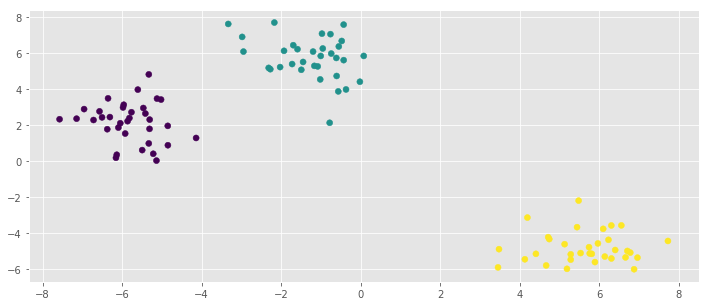

In [29]:
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

100%|██████████| 1000/1000 [00:04<00:00, 213.92it/s]


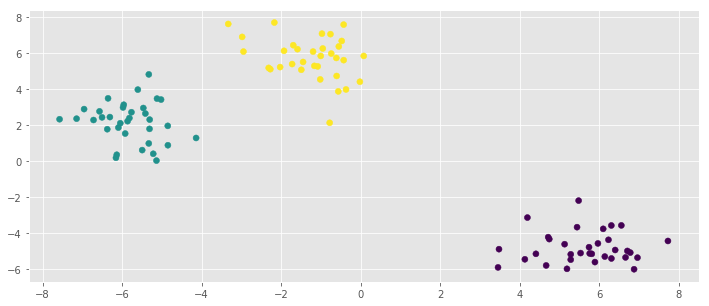

In [30]:
## Работоспособность KMeans
model = Kmeans(k=3, metric='euclidean', max_iter = 1000, init = 'random', early_stop=False)
model.fit(X)
y_predict = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y_predict)
plt.show()

100%|██████████| 1000/1000 [00:04<00:00, 210.53it/s]


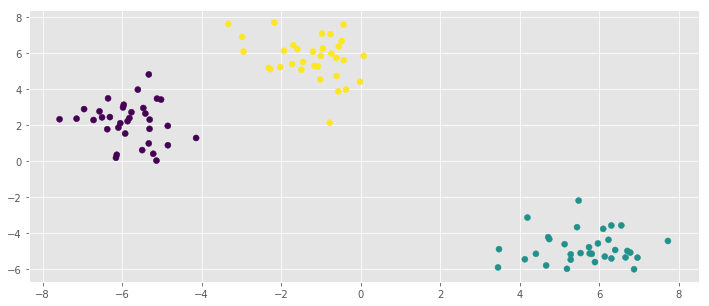

In [31]:
## Работоспособность KMeans++
model = Kmeans(k=3, metric='euclidean', max_iter = 1000, init = 'k-means++', early_stop=False)
model.fit(X)
y_predict = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y_predict)
plt.show()

100%|██████████| 1000/1000 [00:01<00:00, 874.90it/s]


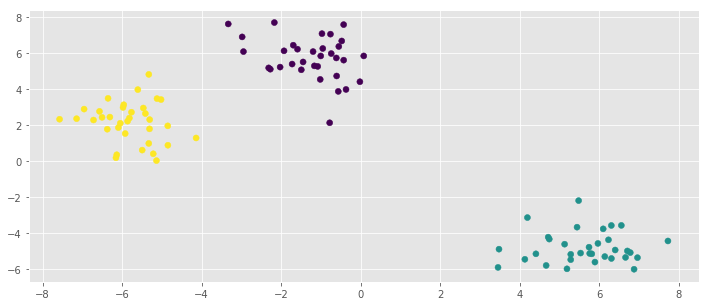

In [41]:
## Работоспособность KMeans с MiniBatchKMeans
model = MiniBatchKMeans(k=3, metric='euclidean', max_iter = 1000, init = 'random', early_stop=False)
model.fit(X, batch_size=20)
y_predict = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y_predict)
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1042.12it/s]


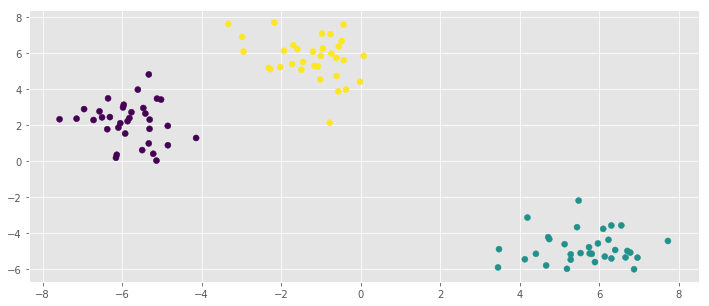

In [43]:
## Работоспособность KMeans++ с MiniBatchKMeans
model = MiniBatchKMeans(k=3, metric='euclidean', max_iter = 1000, init = 'k-means++', early_stop=False)
model.fit(X, batch_size=20)
y_predict = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y_predict)
plt.show()

In [44]:
def get_big_data(i): #Function for getting bigger data
    X_small = X[np.random.choice(X.shape[0], i%100, replace = False)]
    X_big = np.repeat(X, i/100, axis=0)
    return np.concatenate([X_big, X_small])
RESULTS = {}

100%|██████████| 10/10 [06:17<00:00, 56.52s/it]


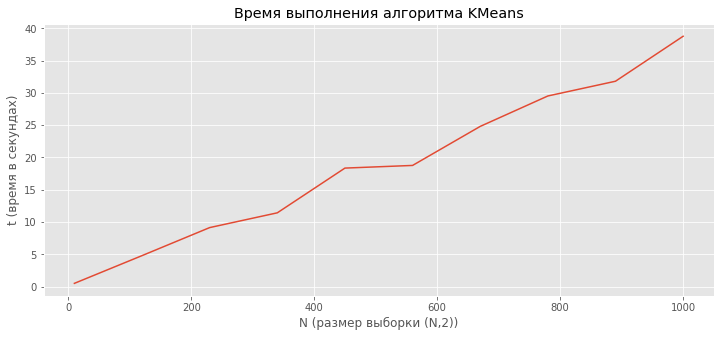

In [45]:
## Время выполнения алгоритма KMeans
model = Kmeans(k=3, metric='euclidean', max_iter = 1000, init = 'random', early_stop=False, verbose=False)
res = {}
for i in tqdm(np.linspace(10,1000,10)):
    X_new = get_big_data(int(i))
    temp = %timeit -r 1 -q -o model.fit(X_new)
    res[X_new.shape[0]] = temp.average
plt.title(u'Время выполнения алгоритма KMeans')
plt.xlabel("N (размер выборки (N,2))")
plt.ylabel("t (время в секундах)")
plt.plot(list(res.keys()), list(res.values()))
plt.show()
RESULTS['KM_random'] = res

100%|██████████| 10/10 [06:03<00:00, 52.22s/it]


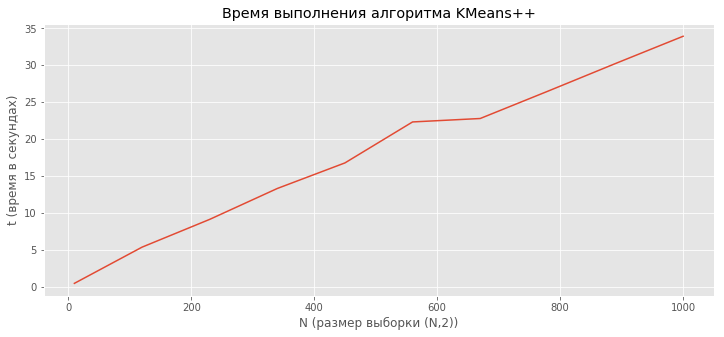

In [47]:
## Время выполнения алгоритма KMeans++
model = Kmeans(k=3, metric='euclidean', max_iter = 1000, init = 'k-means++', early_stop=False, verbose=False)
res = {}
for i in tqdm(np.linspace(10,1000,10)):
    X_new = get_big_data(int(i))
    temp = %timeit -r 1 -q -o model.fit(X_new)
    res[X_new.shape[0]] = temp.average
plt.title(u'Время выполнения алгоритма KMeans++')
plt.xlabel("N (размер выборки (N,2))")
plt.ylabel("t (время в секундах)")
plt.plot(list(res.keys()), list(res.values()))
plt.show()
RESULTS['KM_plus'] = res


100%|██████████| 100/100 [03:12<00:00,  1.72s/it]


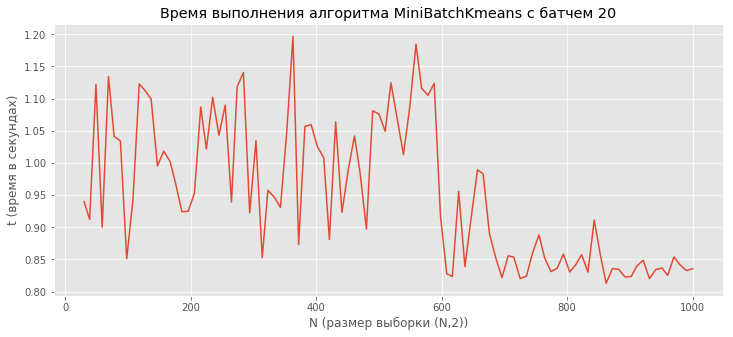

In [64]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
model = MiniBatchKMeans(k=3, metric='euclidean', max_iter = 1000, init = 'random', early_stop=False, verbose=False)
res = {}
for i in tqdm(np.linspace(30,1000,100)):
    X_new = get_big_data(int(i))
    temp = %timeit -r 1 -q -o model.fit(X_new, batch_size=20)
    res[X_new.shape[0]] = temp.average
plt.title(u'Время выполнения алгоритма MiniBatchKmeans с батчем 20')
plt.xlabel("N (размер выборки (N,2))")
plt.ylabel("t (время в секундах)")
plt.plot(list(res.keys()), list(res.values()))
plt.show()
RESULTS['MKM_random'] = res

100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


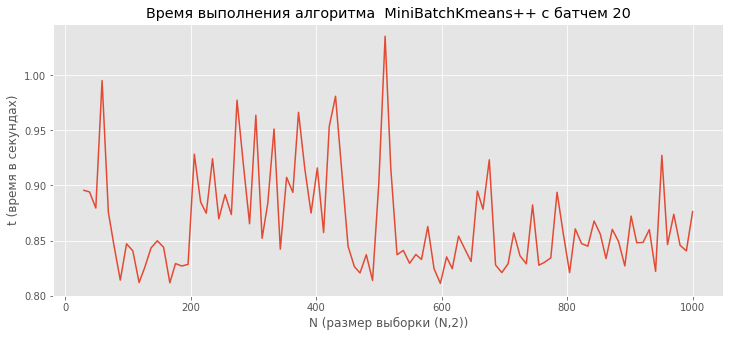

In [65]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
model = MiniBatchKMeans(k=3, metric='euclidean', max_iter = 1000, init = 'k-means++', early_stop=False, verbose=False)
res = {}
for i in tqdm(np.linspace(30,1000,100)):
    X_new = get_big_data(int(i))
    temp = %timeit -r 1 -q -o model.fit(X_new, batch_size=20)
    res[X_new.shape[0]] = temp.average
plt.title(u'Время выполнения алгоритма  MiniBatchKmeans++ с батчем 20')
plt.xlabel("N (размер выборки (N,2))")
plt.ylabel("t (время в секундах)")
plt.plot(list(res.keys()), list(res.values()))
plt.show()
RESULTS['MKM_plus'] = res

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [66]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [67]:
#del features
for key in ['gradyear', 'gender', 'age','friends']:
    del df_sns[key]
#Norm features
for key in df_sns.keys():
    df_sns[key] = (df_sns[key] - df_sns[key].mean())/df_sns[key].std()

In [68]:
from collections import Counter

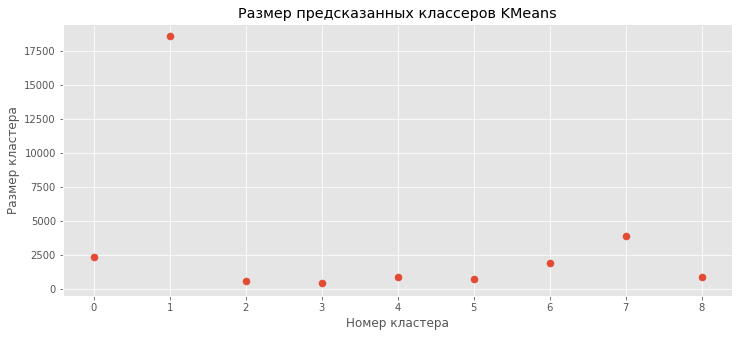

In [72]:
## KMeans
model1 = Kmeans(k=9, metric='euclidean', max_iter = 1000, init = 'random', early_stop=True, verbose=True)
model1.fit(df_sns.get_values())
y_label1 = model1.predict(df_sns.get_values())
temp = Counter(y_label1)
plt.title("Размер предсказанных классеров KMeans")
plt.xlabel("Номер кластера")
plt.ylabel("Размер кластера")
plt.scatter(list(temp.keys()),list(temp.values()), s = 50)
plt.show()

  4%|▎         | 37/1000 [02:07<53:33,  3.34s/it]  

Early stop on iter 37


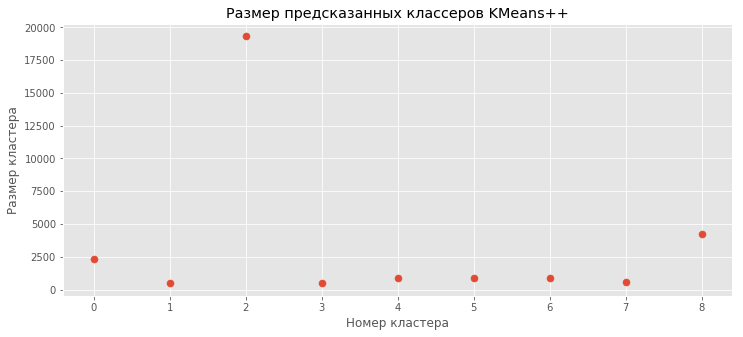

In [75]:
## KMeans++
model2 = Kmeans(k=9, metric='euclidean', max_iter = 1000, init = 'k-means++', early_stop=True, verbose=True)
model2.fit(df_sns.get_values())
y_label2 = model2.predict(df_sns.get_values())
temp = Counter(y_label2)
plt.title("Размер предсказанных классеров KMeans++")
plt.xlabel("Номер кластера")
plt.ylabel("Размер кластера")
plt.scatter(list(temp.keys()),list(temp.values()), s = 50)
plt.show()


100%|██████████| 1000/1000 [02:58<00:00,  5.95it/s]


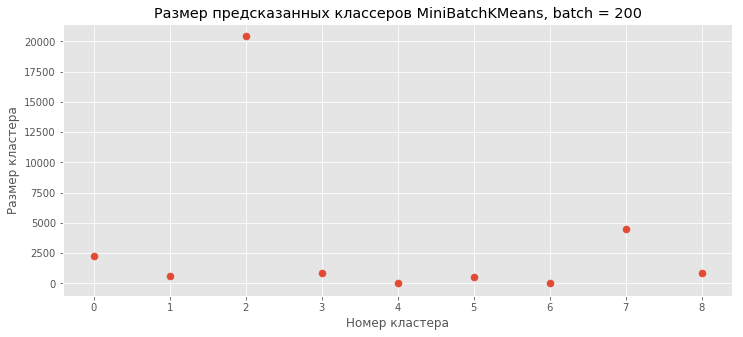

In [73]:
## KMeans с MiniBatchKMeans
model3 = MiniBatchKMeans(k=9, metric='euclidean', max_iter = 1000, init = 'random', early_stop=True, verbose=True)
model3.fit(df_sns.get_values(), batch_size=2000)
y_label3 = model3.predict(df_sns.get_values())
temp = Counter(y_label3)
plt.title("Размер предсказанных классеров MiniBatchKMeans, batch = 200")
plt.xlabel("Номер кластера")
plt.ylabel("Размер кластера")
plt.scatter(list(temp.keys()),list(temp.values()), s = 50)
plt.show()

100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s]


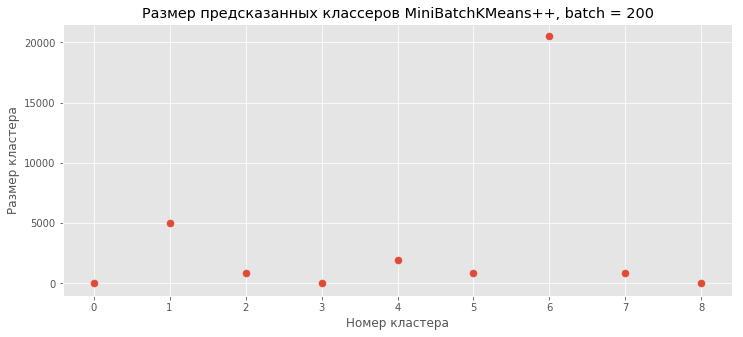

In [74]:
## KMeans++ с MiniBatchKMeans
model4 = MiniBatchKMeans(k=9, metric='euclidean', max_iter = 1000, init = 'k-means++', early_stop=True, verbose=True)
model4.fit(df_sns.get_values(), batch_size=2000)
y_label4 = model4.predict(df_sns.get_values())
temp = Counter(y_label4)
plt.title("Размер предсказанных классеров MiniBatchKMeans++, batch = 200")
plt.xlabel("Номер кластера")
plt.ylabel("Размер кластера")
plt.scatter(list(temp.keys()),list(temp.values()), s = 50)
plt.show()

### Вывод по кластеризации
Как и следовало ожидать, лучшие результаты (количество точек в кластере должно быть примерно одинаковым)
показал Kmeans++ и Kmeans

Все MiniBatchKMeans существенно хуже справилсь с задачей и  иногда ложили 80% точек в один кластер и создавали кластера с одной точкой
MiniBatchKMeans справился с задачей хуже MiniBatchKMeans++, так как не было предварительной иницилизации кластеров

### Посмотрим на кореляцию kmeans++ с признаками и на координаты центроидов, чтобы сделать какие-то выводы

In [83]:
print("1 KMeans:        \t"+str(Counter(y_label1)))
print("2 KMeans++:      \t"+str(Counter(y_label2)))
print("3 KMeans batch:  \t"+str(Counter(y_label3)))
print("4 KMeans++ batch:\t"+str(Counter(y_label4)))

1 KMeans:        	Counter({1: 18546, 7: 3887, 0: 2301, 6: 1860, 4: 853, 8: 839, 5: 748, 2: 580, 3: 386})
2 KMeans++:      	Counter({2: 19315, 8: 4215, 0: 2349, 5: 906, 4: 888, 6: 844, 7: 551, 1: 466, 3: 466})
3 KMeans batch:  	Counter({2: 20413, 7: 4465, 0: 2248, 3: 882, 8: 845, 1: 624, 5: 521, 6: 1, 4: 1})
4 KMeans++ batch:	Counter({6: 20500, 1: 4993, 4: 1972, 2: 871, 7: 832, 5: 829, 3: 1, 0: 1, 8: 1})


#### Будем использовать результаты KMeans++

In [88]:
## Вывод
for i in set(y_label2):
    df_sns["class"+str(i)] = [k==i for k in y_label2]
KEYS = df_sns.keys()[:-9]
used_words = []
for i in ["class"+str(k) for k in range(9)]:
    corr = {k : np.corrcoef(df_sns[i], df_sns[k])[0,1] for k in KEYS}
    print("Len:"+str(sum(df_sns[i])))
    print(('|'+i+" top 5 correlated"+'\t|\t'+'\t|\t\t'+'|'))
    for k,v in sorted(corr.items(), key = lambda x:-abs(x[-1]))[:5]:
        print('|'+'\t|\t'+k+'\t|\t'+str(v)[:8]+'|')
        
    print(('|'+i+" top 5 not correlated"+'\t|\t'+'\t|\t\t'+'|'))
    for k,v in sorted(corr.items(), key = lambda x:abs(x[-1]))[:5]:
        print('|'+'\t|\t'+k+'\t|\t'+str(v)[:8]+'|')
        used_words.append(k)

Len:2349
|class0 top 5 correlated	|		|		|
|	|	basketball	|	0.402610|
|	|	baseball	|	0.374229|
|	|	football	|	0.372647|
|	|	softball	|	0.350645|
|	|	sports	|	0.326409|
|class0 top 5 not correlated	|		|		|
|	|	hot	|	-0.00061|
|	|	god	|	0.003603|
|	|	jesus	|	-0.00431|
|	|	mall	|	-0.00455|
|	|	clothes	|	-0.00468|
Len:466
|class1 top 5 correlated	|		|		|
|	|	bible	|	0.586231|
|	|	jesus	|	0.416484|
|	|	god	|	0.392764|
|	|	church	|	0.289379|
|	|	death	|	0.051077|
|class1 top 5 not correlated	|		|		|
|	|	hot	|	2.475361|
|	|	blonde	|	0.000540|
|	|	marching	|	-0.00086|
|	|	sex	|	-0.00109|
|	|	cheerleading	|	-0.00193|
Len:19315
|class2 top 5 correlated	|		|		|
|	|	shopping	|	-0.38756|
|	|	cute	|	-0.29660|
|	|	mall	|	-0.29444|
|	|	hair	|	-0.29403|
|	|	clothes	|	-0.28826|
|class2 top 5 not correlated	|		|		|
|	|	blonde	|	-0.04006|
|	|	tennis	|	-0.05303|
|	|	jesus	|	-0.10764|
|	|	death	|	-0.10891|
|	|	bible	|	-0.11294|
Len:466
|class3 top 5 correlated	|		|		|
|	|	marching	|	0.737136|
|	|	band	|	0.58

# Вывод

Чтобы было интересно, назовем(сверху вниз по уверенности) описание классов и потом посмотрим на их центроиды

*  Кластер 6: Шмоточники, интересуются брендовой одеждой
*  Кластер 5: Девушки, любят танцы, шмотки, музыку, cute
*  Кластер 7: Озабоченные, постят про секс ( семнадцатилетнии циники), следят за прической, не любят спорт, религию и наркотики
*  Кластер 0: Спортсмены (Если это американская школа, то это парни с буквой R на толстовке)
*  Кластер 1: Фанатики (Верующие)
*  Кластер 3: Рокеры, панки
*  Кластер 4: Нормальные подростки, с подростковыми ценносями
*  Кластер 2: Обычные(Просто самый большой кластер со всеми)
*  Кластер 8: Люди, делающие репосты

In [95]:
for i in range(9):
    print(str(i)+" : "+str(KEYS[np.argmax(model2.centroids[i])]))

0 : basketball
1 : bible
2 : blonde
3 : marching
4 : kissed
5 : dance
6 : hollister
7 : sexy
8 : shopping
